<a href="https://colab.research.google.com/github/aderdouri/ql_web_app/blob/master/ql_notebooks/term_structures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Term structures and their reference dates

In this notebook, I show briefly how to set up term structures so that they track (or don't track) the global evaluation date.

#### Setup

Import the QuantLib module and set up the global evaluation date. You might want to take note of the date, since we'll be moving it around later on.

In [ ]:
!pip install QuantLib-Python

In [1]:
import QuantLib as ql

In [2]:
ql.Settings.instance().evaluationDate = ql.Date(3, ql.October, 2014)

#### Specifying the reference date of a term structure

In not-too-accurate terms, the reference date of a term structure is where it begins.  It can be the evaluation date, but you might also want it to start on the spot date, for instance.

We have two possibilities to define a reference date for a curve&mdash;even though some particular classes only allow one of them.

The first is to define it by means of a (possibly null) offset from the current evaluation date; e.g., "two business days after the evaluation date" to define it as the spot date, or "no business days" to define it as the evaluation date itself. I'll do it here by building a sample curve over a few swaps.

Never mind the helper object that I'm building here...

In [3]:
helpers = [ ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100.0)),
                              ql.Period(*tenor), ql.TARGET(),
                              ql.Annual, ql.Unadjusted, 
                              ql.Thirty360(ql.Thirty360.BondBasis), 
                              ql.Euribor6M())
            for tenor, rate in [((2,ql.Years), 0.201),
                                ((3,ql.Years), 0.258),
                                ((5,ql.Years), 0.464),
                                ((10,ql.Years), 1.151),
                                ((15,ql.Years), 1.588)] ]

...because the construction of the curve is the main point: note the `0` and `TARGET()` arguments, specifying the number of days and the calendar used to determine business days.

In [4]:
curve1 = ql.PiecewiseFlatForward(0, ql.TARGET(), helpers, ql.Actual360())

The second possibility is to specify the reference date explicitly. For instance, the `ForwardCurve` class takes a vector of specific dates and the corresponding rates and interpolates between them; the first passed date is taken as the reference date of the curve.

For comparison purposes, I'll ask the curve above for its nodes and use them to build a `ForwardCurve` instance:

In [5]:
dates, rates = zip(*curve1.nodes())

In [6]:
curve1.nodes()

((Date(3,10,2014), 0.0019777694879293093),
 (Date(7,10,2016), 0.0019777694879293093),
 (Date(9,10,2017), 0.0036475517704509294),
 (Date(7,10,2019), 0.007660760701876805),
 (Date(7,10,2024), 0.018414773669420893),
 (Date(8,10,2029), 0.025311634328221498))

The curve built based on these data will be the same as the first, except that we're specifying its reference date explicitly as October 3rd (the first passed date).

In [7]:
curve2 = ql.ForwardCurve(dates, rates, ql.Actual360())

Both curves are defined over the same range of dates...

In [8]:
print("{0} to {1}".format(curve1.referenceDate(), curve1.maxDate()))
print("{0} to {1}".format(curve2.referenceDate(), curve2.maxDate()))

October 3rd, 2014 to October 8th, 2029
October 3rd, 2014 to October 8th, 2029


...and return the same rates, whether we ask for a given time (for instance, 5 years)...

In [9]:
print(curve1.zeroRate(5.0, ql.Continuous))
print(curve2.zeroRate(5.0, ql.Continuous))

0.452196 % Actual/360 continuous compounding
0.452196 % Actual/360 continuous compounding


...or for a given date.

In [10]:
print(curve1.zeroRate(ql.Date(7, ql.September, 2019),
                      ql.Actual360(), ql.Continuous))
print(curve2.zeroRate(ql.Date(7, ql.September, 2019),
                      ql.Actual360(), ql.Continuous))

0.452196 % Actual/360 continuous compounding
0.452196 % Actual/360 continuous compounding


With the help of a couple more Python modules, we can also plot the whole curve by asking for rates over a set of times:

In [11]:
%matplotlib inline
import utils
from matplotlib.ticker import FuncFormatter
import numpy as np

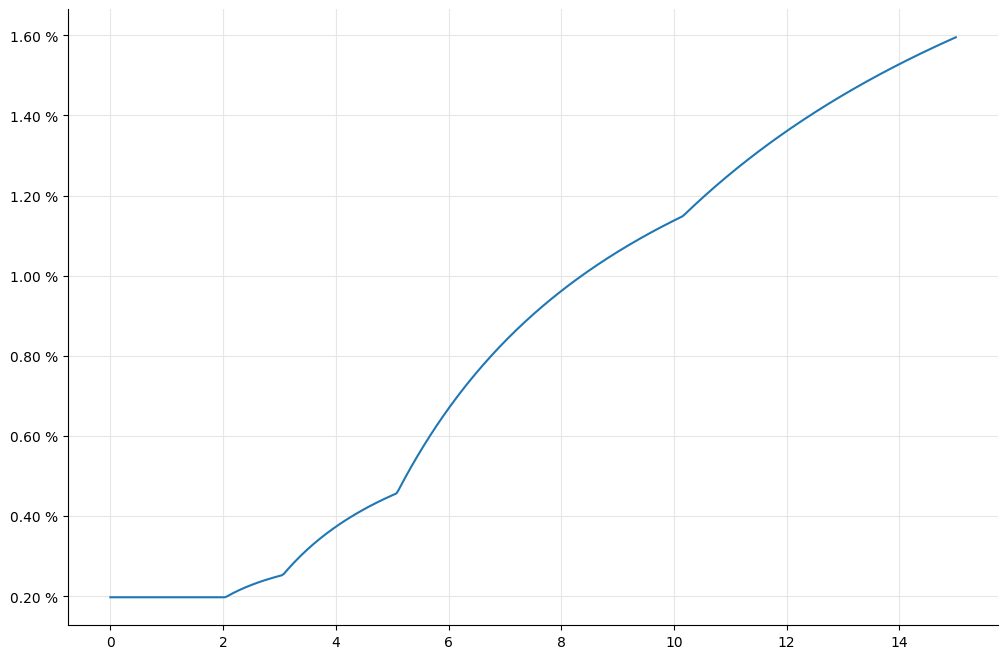

In [12]:
times = np.linspace(0.0, 15.0, 400)
rates = [ curve1.zeroRate(t, ql.Continuous).rate() for t in times ]
_, ax = utils.plot()
ax.yaxis.set_major_formatter(
    FuncFormatter(lambda r,pos: utils.format_rate(r,2)))
ax.plot(times, rates);

#### Moving the evaluation date

To recap: we built the first curve specifying its reference date relative to the evaluation date, and the second curve specifying its reference date explicitly. Now, what happens if we change the evaluation date?

In [13]:
ql.Settings.instance().evaluationDate = ql.Date(19, ql.September, 2014)

As you might expect, the reference date of the first curve changes accordingly while that of the second curve doesn't.

We can see how the range of definition has now changed for the first curve, but not for the second:

In [14]:
print("{0} to {1}".format(curve1.referenceDate(), curve1.maxDate()))
print("{0} to {1}".format(curve2.referenceDate(), curve2.maxDate()))

September 19th, 2014 to September 24th, 2029
October 3rd, 2014 to October 8th, 2029


And of course the rates have changed, too...

In [15]:
print(curve1.zeroRate(5.0, ql.Continuous))
print(curve2.zeroRate(5.0, ql.Continuous))

0.452196 % Actual/360 continuous compounding
0.452196 % Actual/360 continuous compounding


...if we look at them in the right way. The whole curve has moved back a couple of weeks, so if we ask for a given time we'll get the same rates; in other words, we're asking for the zero rate over five years after the reference date, and that remains the same for a rigid translation of the curve.  If we ask for the zero rate at a given date, though, we'll see the effect:

In [16]:
print(curve1.zeroRate(ql.Date(7, ql.September, 2019),
                      ql.Actual360(), ql.Continuous))
print(curve2.zeroRate(ql.Date(7, ql.September, 2019),
                      ql.Actual360(), ql.Continuous))

0.454618 % Actual/360 continuous compounding
0.452196 % Actual/360 continuous compounding


#### Notifications

Finally, we can see how the two curves behave differently also with respect to notifications. Let's make two observers...

In [17]:
def make_observer(i):
    def say():
        s = "Observer %d notified" % i
        print('-'*len(s))
        print(s)
        print('-'*len(s))
    return ql.Observer(say)

obs1 = make_observer(1)
obs2 = make_observer(2)

...and check that they work correctly by connecting them to a few quotes. The first observer will receive notifications from the first and third quote, and the second observer will receive notifications from the second and third quote.

In [18]:
q1 = ql.SimpleQuote(1.0)
obs1.registerWith(q1)

q2 = ql.SimpleQuote(2.0)
obs2.registerWith(q2)

q3 = ql.SimpleQuote(3.0)
obs1.registerWith(q3)
obs2.registerWith(q3)

If I trigger a change in the first quote, the first observer is notified and outputs a message:

In [19]:
q1.setValue(1.5)

-------------------
Observer 1 notified
-------------------


A change in the second quote causes a message from the second observer...

In [20]:
q2.setValue(1.9)

-------------------
Observer 2 notified
-------------------


...and a change in the third quote causes both observers to react.

In [21]:
q3.setValue(3.1)

-------------------
Observer 1 notified
-------------------
-------------------
Observer 2 notified
-------------------


Now let's connect the observers to the curves. The first observer will receive notifications from the curve that moves with the evaluation date, and the second observer will receive notifications from the curve that doesn't move.

In [22]:
obs1.registerWith(curve1)
obs2.registerWith(curve2)

Now we can see what happens when the evaluation date changes again:

In [23]:
ql.Settings.instance().evaluationDate = ql.Date(23, ql.September, 2014)

-------------------
Observer 1 notified
-------------------


As you can see, only the moving curve sent a notification. The other did not, since it was not modified by the change of evaluation date.